### What is Florence-2?

Florence-2 is a vision-language model developed by Microsoft that understands both images and text. It is a multimodal model capable of various tasks, including:

*   Generating image captions
*   Detecting the location of objects in an image
*   Performing optical character recognition (OCR)


Florence-2 supports zero-shot object detection, which means it can detect and classify objects it hasn't seen during training—without requiring additional fine-tuning on those specific classes.

The model is trained on the FLD-5B dataset, which contains 5.4 billion annotations across 126 million images, enabling it to handle a wide range of vision-language tasks through multi-task learning.

With its sequence-to-sequence architecture, Florence-2 excels in both zero-shot and fine-tuned settings, making it a competitive foundation model in the vision domain.

<img src="https://github.com/ultralytics/notebooks/releases/download/v0.0.0/florence-2-architecture.png" alt="Florence 2 Architecture" />


### Configure your API keys

To download florence-2 model from hugging face, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page.
Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.


In [3]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")


#**Install All the Required Packages**

In [4]:
!pip install ultralytics
!pip install transformers==4.49.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


#**Import All the Required Libraries**

In [5]:
import cv2
import numpy as np
import torch
import ultralytics
from PIL import Image
from IPython.display import display
from transformers import AutoModelForCausalLM, AutoProcessor
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.8/112.6 GB disk)


#**Download Florence-2 Model**

We will use the transformers library to fetch the Florence-2 large model from hugging face

In [6]:
!pwd

/content


In [7]:
model_id = "microsoft/Florence-2-large"

# Please make sure that you set the run time as GPU in Colab

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True,torch_dtype="auto").eval().cuda()
processor = AutoProcessor.from_pretrained(model_id)

config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

The repository for microsoft/Florence-2-large contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/Florence-2-large.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

#**Inference Function**

In this notebook, we will explore various operations using the Florence-2 model. We will define an inference function capable of handling image captioning, object detection, OCR and more.

In [8]:
def inference(image, task_prompt, text_input=None):
    """
    Performs inference using the given image and task prompt.

    Args:
        image (PIL.Image or tensor): The input image for processing.
        task_prompt (str): The prompt specifying the task for the model.
        text_input (str, optional): Additional text input to refine the prompt.

    Returns:
        dict: The model's processed response after inference.
    """
    # 01. Combine task prompt with additional text input if provided
    prompt = task_prompt if text_input is None else task_prompt + text_input

    # 02. Generate Input Data for Model Processing from the given Prompt and Image
    inputs = processor(
        text=prompt,  # Text input for the model
        images=image,  # Image input for the model
        return_tensors="pt",  # Return PyTorch tensors
    ).to("cuda", torch.float16)  # Move inputs to GPU with float16 precision

    # 03, Generate model predictions (token IDs)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),  # text input IDs to CUDA
        pixel_values=inputs["pixel_values"].cuda(),  # pixel values to CUDA
        max_new_tokens=1024,  # Set maximum number of tokens to generate
        early_stopping=False,  # Disable early stopping
        do_sample=False,  # Use deterministic inference
        num_beams=3,  # Set beam search width for better predictions
    )

    # 04. Decode generated token IDs into text
    generated_text = processor.batch_decode(
        generated_ids,  # Generated token IDs
        skip_special_tokens=False,  # Retain special tokens in output
    )[0]  # Extract first result from batch

    # Post-process the generated text into a structured response
    parsed_answer = processor.post_process_generation(
        generated_text,  # Raw generated text
        task=task_prompt,  # Task type for post-processing
        image_size=(image.width, image.height),  # scaling output
    )

    return parsed_answer  # Return the final processed output

#**Download the Image**

In [9]:
!gdown "https://drive.google.com/uc?id=1Xa1EJO_Uwv-qr0i72VK2TaQALz7X0EP1&confirm=t"

!gdown "https://drive.google.com/uc?id=18Xgsde2kqS4d_rTMQBVID-HV0-tKrKEK&confirm=t"

!gdown "https://drive.google.com/uc?id=1hENIYtFe0d3Bw6WOESGdlTIpA02C8HdC&confirm=t"

!gdown "https://drive.google.com/uc?id=1sR4AnECgwYb_UdiGp11E_UOhzfbvSmLI&confirm=t"

!gdown "https://drive.google.com/uc?id=1x3nP8aBokT9H5nbQXIZuMw4ijrct70UW&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1Xa1EJO_Uwv-qr0i72VK2TaQALz7X0EP1&confirm=t
To: /content/image.jpg
100% 214k/214k [00:00<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Xgsde2kqS4d_rTMQBVID-HV0-tKrKEK&confirm=t
To: /content/bus.jpg
100% 137k/137k [00:00<00:00, 95.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hENIYtFe0d3Bw6WOESGdlTIpA02C8HdC&confirm=t
To: /content/baggage_claim.jpg
100% 55.4k/55.4k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sR4AnECgwYb_UdiGp11E_UOhzfbvSmLI&confirm=t
To: /content/handwritten_image.png
100% 262k/262k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x3nP8aBokT9H5nbQXIZuMw4ijrct70UW&confirm=t
To: /content/soccer.jpg
100% 297k/297k [00:00<00:00, 96.4MB/s]


#**Read the Image**

In [10]:
def read_image(filename):
    # Read image using OpenCV and convert to RGB for PIL
    image = cv2.imread(filename)
    return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

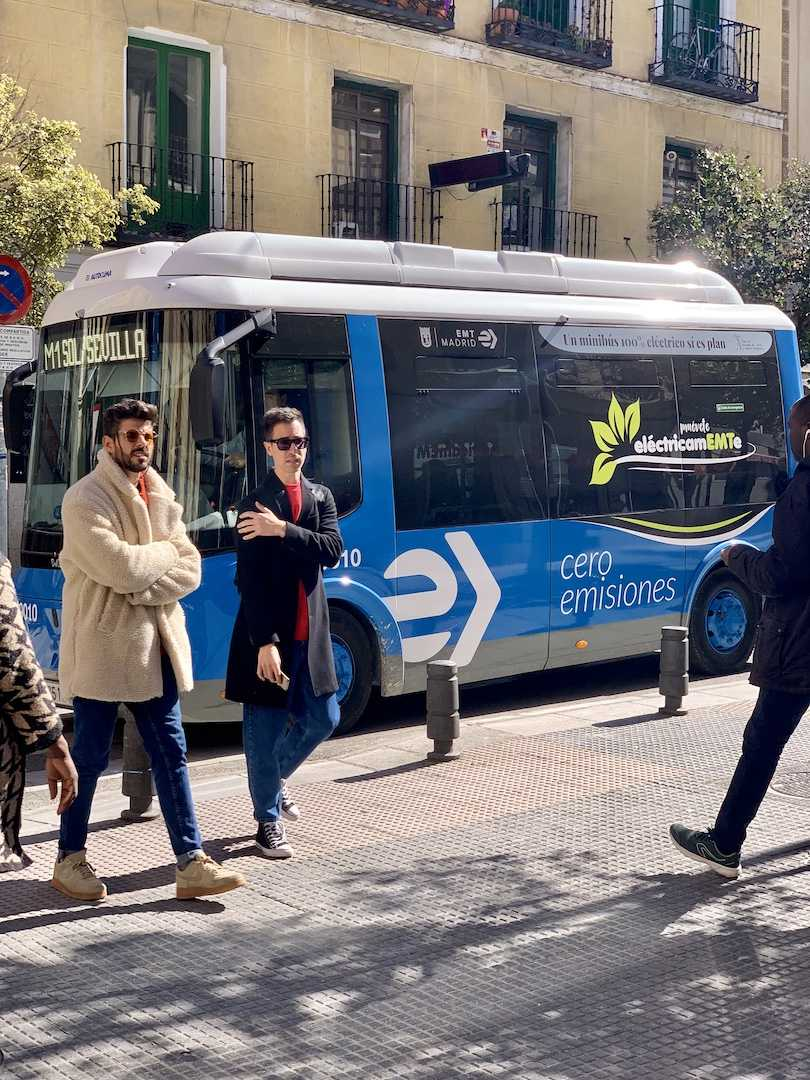

In [11]:
read_image(filename="/content/bus.jpg")

With the model loaded into memory, the input image ready for processing, and functions in place for preprocessing and post-processing, it's time to play some magic with Florence-2. 🚀

### Object detection  

Florence-2 supports object detection, allowing us to efficiently identify and recognize various objects within an image.

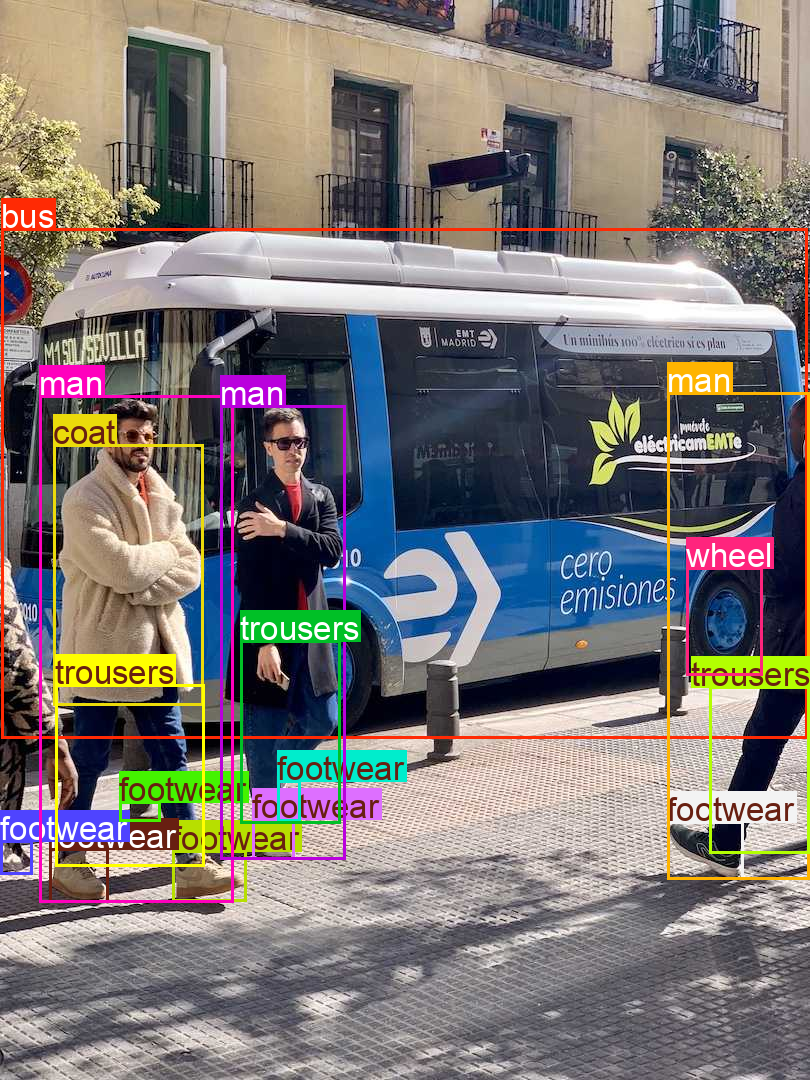

In [12]:
"""
# Result format 😀
{
    "<OD>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""
task_prompt = "<OD>" # Object Detection

image = read_image (filename="/content/bus.jpg")

results = inference (image, task_prompt)["<OD>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
    annotator.box_label(box, label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

### Caption  

Generate captions for an input image without providing a custom prompt. By default, Caption feature in Florence-2 provides three levels of captions:

- `CAPTION`
- `DETAILED_CAPTION`
- `MORE_DETAILED_CAPTION`.  

🚀 `CAPTION` is generally more accurate, while `DETAILED_CAPTION` and `MORE_DETAILED_CAPTION` may not always be as precise.

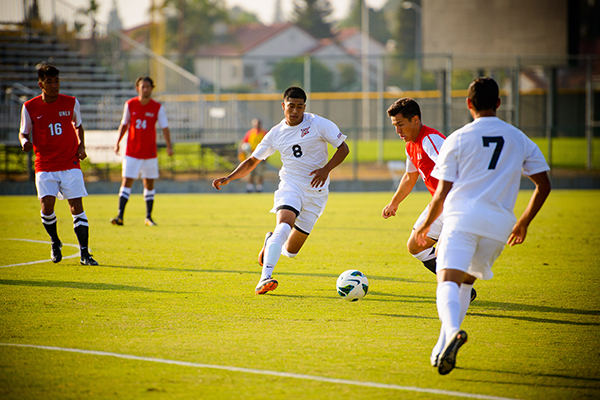

In [13]:
display(Image.open("/content/soccer.jpg"))

In [14]:
task_prompt = "<CAPTION>"
inference(read_image(filename="/content/soccer.jpg"), task_prompt)

{'<CAPTION>': 'A group of young men playing soccer on a field.'}

In [15]:
task_prompt = "<DETAILED_CAPTION>"
inference(read_image("/content/soccer.jpg"), task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a group of young men playing soccer on a grassy field surrounded by a fence, poles, trees, buildings, and steps. The background is slightly blurred, giving the image a sense of motion and energy.'}

In [16]:
task_prompt = "<MORE_DETAILED_CAPTION>"
inference(read_image("/content/soccer.jpg"), task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a group of young men playing soccer on a grassy field. There are four players in the image, three of whom are wearing white jerseys with the number 8 on them. The player in the center of the image is dribbling the ball towards the goal, while the other two players are running towards him. The third player, wearing a red jersey, is attempting to dribble past the defender, who is wearing a white jersey with the numbers 7 on it. The fourth player is running towards the ball, trying to block the shot. In the background, there are other players from both teams wearing red jerseys, and a few spectators can be seen watching the game. The field is surrounded by a fence and there are trees and buildings visible in the distance.'}

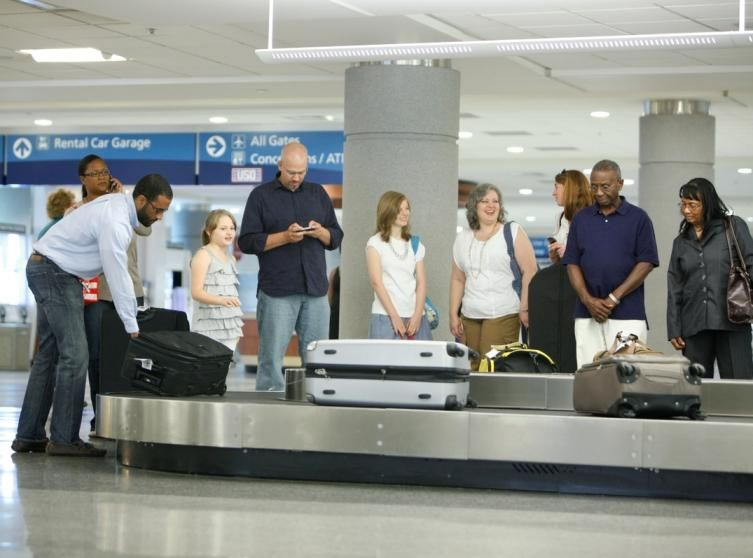

In [17]:
display(Image.open("/content/baggage_claim.jpg"))

In [18]:
task_prompt = "<CAPTION>"
inference(read_image(filename="/content/baggage_claim.jpg"), task_prompt)

{'<CAPTION>': 'A group of people standing around a baggage claim area.'}

In [19]:
task_prompt = "<DETAILED_CAPTION>"
inference(read_image("/content/baggage_claim.jpg"), task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a group of people standing around a baggage claim at an airport, with some of them holding bags and one person holding a mobile phone. There are several suitcases on the conveyor belt, and in the background there are boards with text on them, as well as pillars and lights on the ceiling.'}

In [20]:
task_prompt = "<MORE_DETAILED_CAPTION>"
inference(read_image("/content/baggage_claim.jpg"), task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a group of people standing around a baggage claim area at an airport. There are six people in the image, three men and three women, all of whom appear to be of different ages and ethnicities. They are standing in front of a conveyor belt with several suitcases on it. The man on the left is bending down to pick up a black suitcase, while the man in the middle is looking at his phone. The woman on the right is holding a yellow bag and appears to be checking in. In the background, there is a sign that reads "Rental Car Garage" and another sign that says "All-in-one car garage." The people are looking at their phones and seem to be engaged in conversation.'}

#**Dense Region Caption**

For more precise results, such as specific locations, cities, places, or object types, we can use dense region captioning. Instead of a general caption like `"a bus in an image,"` we can obtain a more detailed description, such as `"an electric bus in Madrid, Spain."`

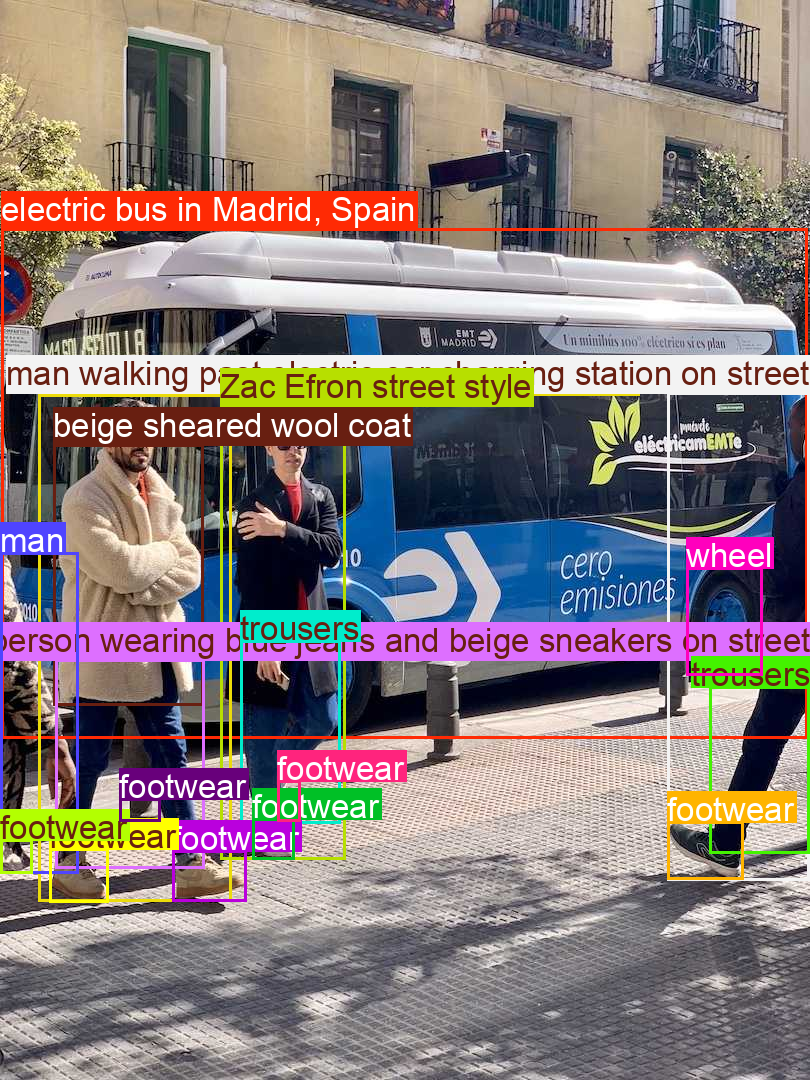

In [21]:
"""
# Result format 😀
{
    "<DENSE_REGION_CAPTION>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<DENSE_REGION_CAPTION>"

image = read_image(filename="/content/bus.jpg")

results = inference(image, task_prompt)["<DENSE_REGION_CAPTION>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
    annotator.box_label(box, label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

### Region proposal

Region proposal refers to the process of identifying areas in an image that are likely to contain objects. It helps in object detection by suggesting potential object locations before classification and bounding box refinement.

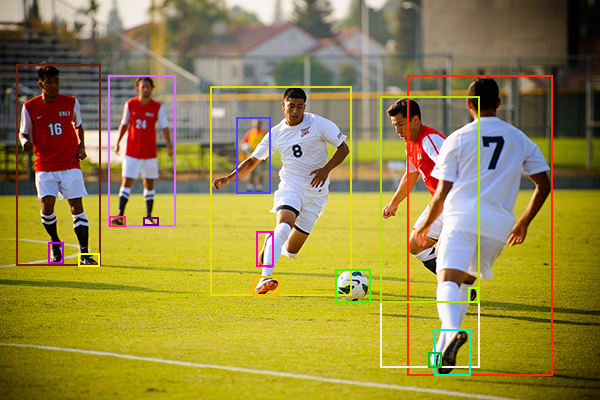

In [22]:
"""
# Results format 🎉
{
    "<REGION_PROPOSAL>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<REGION_PROPOSAL>"

image = read_image(filename = "/content/soccer.jpg")

results = inference(image, task_prompt)["<REGION_PROPOSAL>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator
for idx, box in enumerate(results["bboxes"]):
    x1, y1, x2, y2 = box
    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    # Update the bounding box correctly
    annotator.box_label([x1, y1, x2, y2], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

## OCR related tasks

Florence 2 can also be utilized for OCR-related tasks.

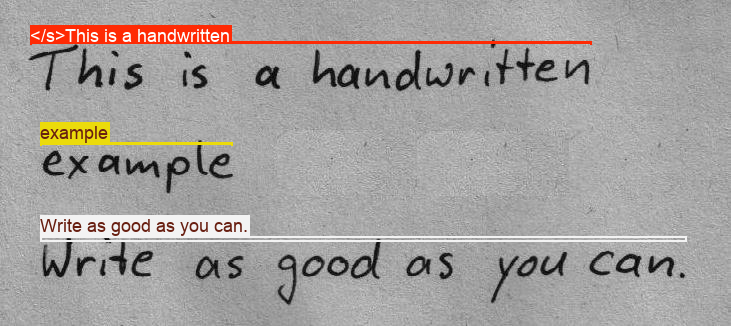

In [23]:
# Download and read the sample image for OCR
image = read_image(filename="/content/handwritten_image.png")

task_prompt = "<OCR_WITH_REGION>"
results = inference(image, task_prompt)["<OCR_WITH_REGION>"]

# segmentation mask function required the numpy array image, not PIL based image.
annotator = Annotator(image, line_width=2)

for idx, (box, label) in enumerate(zip(results["quad_boxes"], results["labels"])):
    box = box[:4]
    x1, y1, x2, y2 = box
    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    # Update the bounding box correctly
    annotator.box_label([x1, y1, x2, y2], label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output